### Imports and utility functions

In [1]:
import os
import warnings

from requests import get
import numpy as np

# Rasterio and friends
import rasterio
from rio_toa.reflectance import calculate_landsat_reflectance
from rio_toa.brightness_temp import calculate_landsat_brightness_temperature
from rio_toa.toa_utils import rescale, _parse_bands_from_filename
from rio_cloudmask.equations import cloudmask
from rio_color.operations import parse_operations 

# Plotting
%matplotlib inline
from rasterio.plot import show
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

warnings.filterwarnings('ignore')

datadir = "_data"

In [2]:
def download(url, file_name):
    if not os.path.exists(file_name):
        with open(file_name, "wb") as file:
            response = get(url)
            if response.status_code != 200:
                raise Exception('Cant get' + url)
            file.write(response.content)
        

def get_data(sceneid):
    os.makedirs(os.path.join(datadir, sceneid), exist_ok=True)
    
    path = sceneid[3:6]
    row = sceneid[6:9]
    baseurl = "http://landsat-pds.s3.amazonaws.com/L8/{path}/{row}/{sceneid}/".format(
        path=path, row=row, sceneid=sceneid)
    
    filenames = [os.path.join(datadir, sceneid, sceneid + "_B{}.TIF.ovr".format(band))
                 for band in (2, 3, 4, 5, 6, 7, 9, 10)]

    urls = [baseurl + os.path.basename(fname) for fname in filenames]
    
    for url, fname in zip(urls, filenames):
        download(url, fname.replace('.ovr', ''))
    
    mtl_fname = os.path.join(datadir, sceneid, sceneid + "_MTL.json")
    mtl_url = baseurl + os.path.basename(mtl_fname)
    download(mtl_url, mtl_fname)
    
    # strip ovr
    filenames = [f.replace('.ovr', '') for f in filenames]
    
    return filenames, mtl_fname


def read_toa(fname, mtl):
    bandnum = _parse_bands_from_filename([fname], '.*/LC8.*\_B{b}.TIF')

    if bandnum[0] in (10, 11):
        calculate_landsat_brightness_temperature(
            fname, mtl, '/tmp/toa.tif', 'C', {}, 10, 'float32', 8)
    else:
        calculate_landsat_reflectance(
            [fname], mtl, '/tmp/toa.tif', 1.0, {}, bandnum, 'float32', 8, False)
    
    with rasterio.open('/tmp/toa.tif') as src:
        arr = src.read(1)
    return arr

## Analysis

In [3]:
def plot_scene_clouds(sceneid):
    # Fetch
    band_files, mtl = get_data(sceneid)
    
    # TOA
    bands = [read_toa(f, mtl) for f in band_files] 
    
    # Cloudmasking
    cloud, shadow = cloudmask(*bands)
    
    # Create RGB and color
    rgb = np.array([bands[2], bands[1], bands[0]])
    for func in parse_operations("sigmoidal rgb 25 0.05"):
        rgb = func(rgb)
        
    # Create aggregate mask   
    mask = cloud | shadow | (np.isnan(bands[-1]))

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(18, 9))
    show(rgb, ax=axs[0])
    show(mask, cmap=cm.Greys, ax=axs[1])

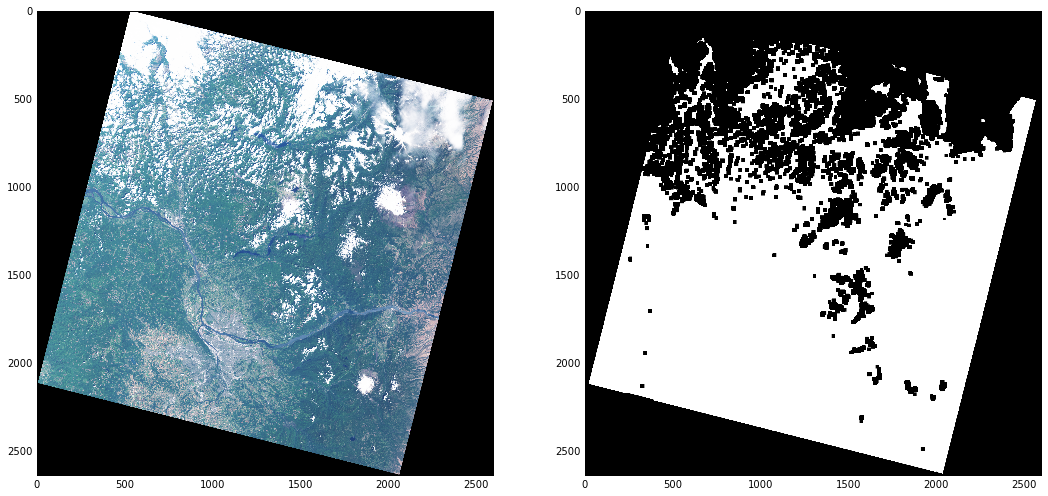

In [4]:
plot_scene_clouds('LC80460282016177LGN00')

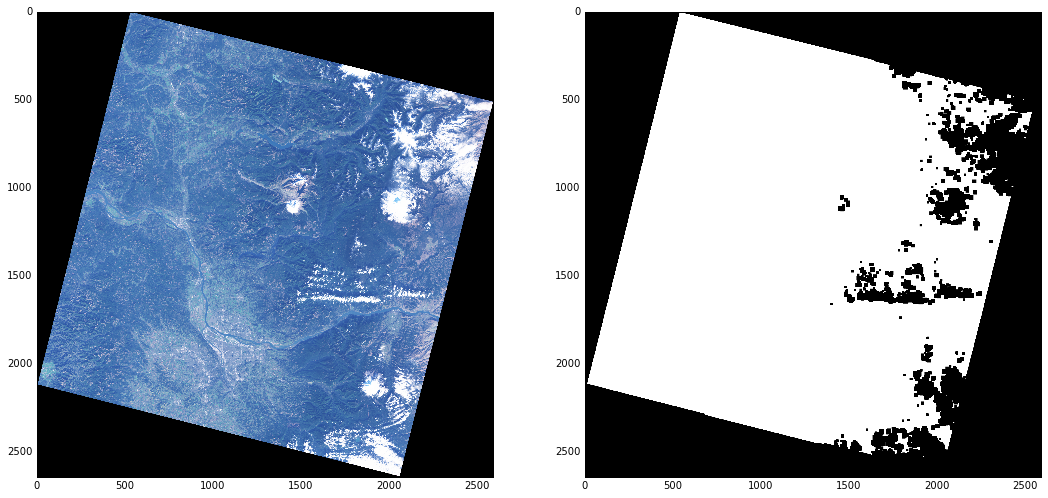

In [5]:
plot_scene_clouds('LC80460282014315LGN00')

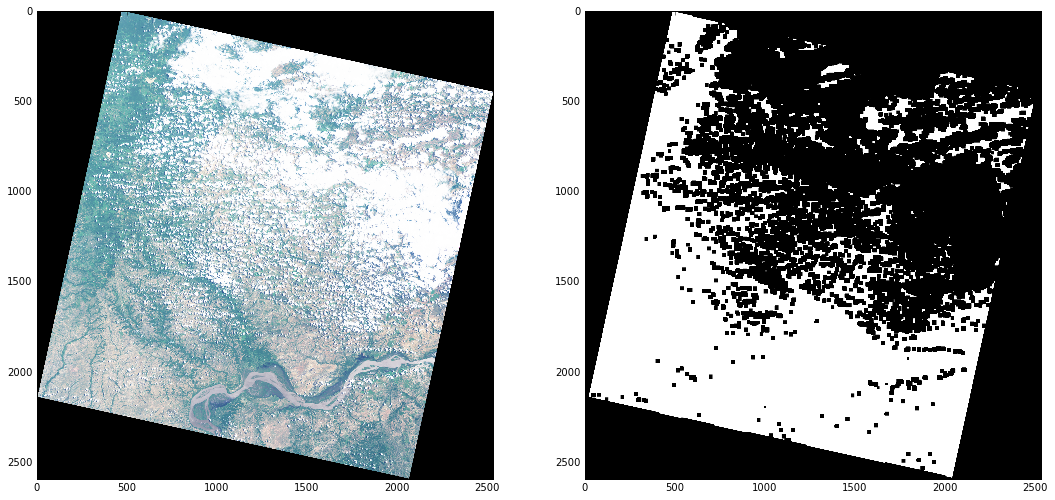

In [6]:
plot_scene_clouds('LC80020542016221LGN00')

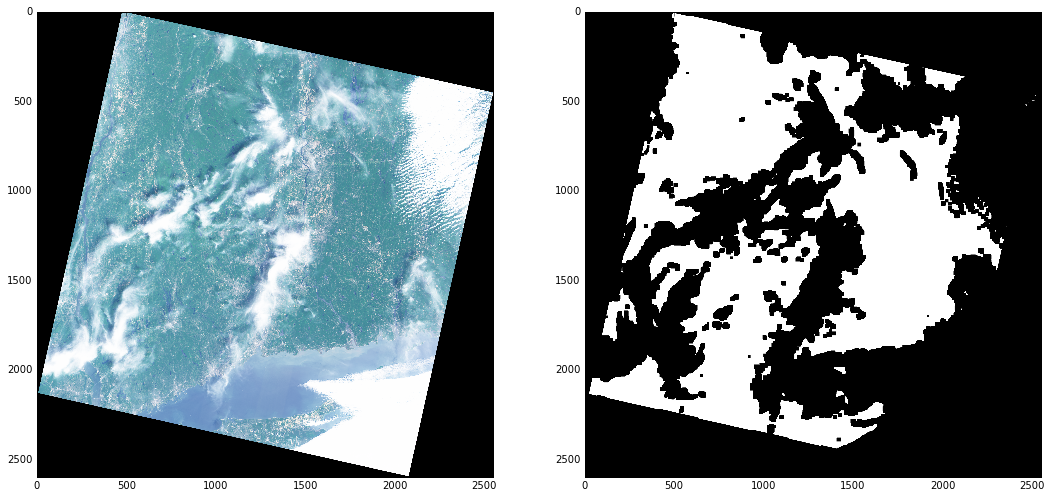

In [7]:
plot_scene_clouds('LC80130312016154LGN00')

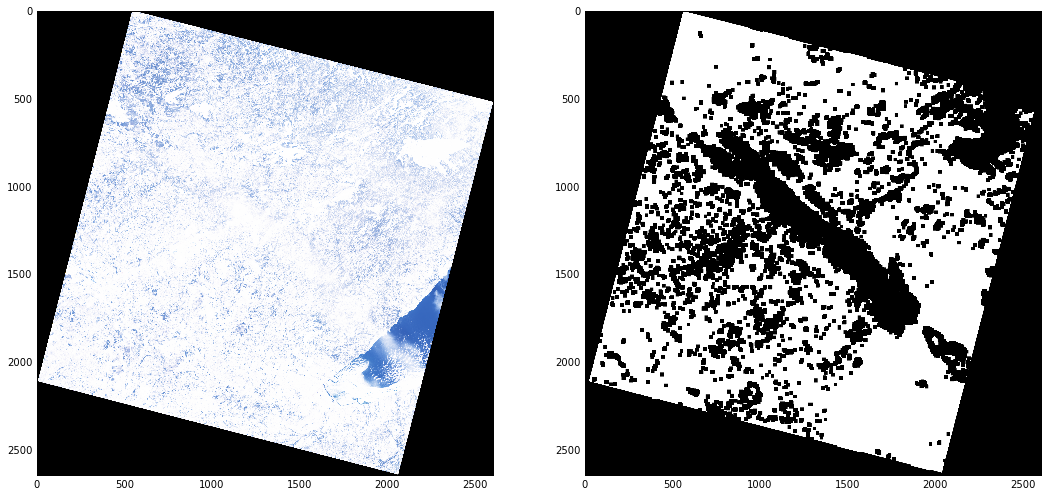

In [8]:
plot_scene_clouds('LC80270272016044LGN00')